In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
  

In [ ]:
import dolfin
import scipy.linalg as spla
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline

In [ ]:
import os

user = "highlando"
repo = "spacetime_galerkin_pod"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

In [ ]:
import sys

src_dir = "multidim_galerkin_pod"
repo = "spacetime_galerkin_pod"
path = f"{repo}/{src_dir}"
if not path in sys.path:
    sys.path.insert(1, path)

# list all directories in the Python path
print("\n".join(["'" + path + "'" for path in sys.path]))

In [ ]:
import sys

src_dir = "multidim_galerkin_pod"

sys.path.insert(1, f"{repo}/{src_dir}")
import ldfnp_ext_cholmod

Cannot import sksparse -- hope we can do without
Caution: solving with the factor F uses dense routines


In [ ]:
dolfin.parameters['linear_algebra_backend'] = 'Eigen'

nu = 1e-4  # the viscosity

N = 50 
poddim = 40

t0, tE, Nts = 0., .8, 101  # the time grid for the snapshots
timegrid = np.linspace(t0, tE, Nts)

plt.style.use('bmh')
vmax = 2.5  # uniform scaling for the plot colors
nplts = 6  # number of plots
pltgrid = [x*np.int(np.floor(Nts/(nplts-1))) for x in range(nplts)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
pone = dolfin.Point(-1, -1)
ptwo = dolfin.Point(1, 1)
mesh = dolfin.RectangleMesh(pone, ptwo, N, N)

In [ ]:
V = dolfin.VectorFunctionSpace(mesh, 'CG', 2)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_3d(coordinates_X, coordinates_Y, sol, time):
  fig = plt.figure(figsize=(6,6))
  ax = plt.axes(projection='3d')
  inivvec = sol[:,time]

  surf = ax.scatter3D(coordinates_X, coordinates_Y, inivvec, c = inivvec, marker='o', s=100, cmap="coolwarm")
  cb = fig.colorbar(surf, shrink=0.5, aspect=5)
  cb.outline.set_edgecolor('white')
  plt.title("Reduced-solution at the terminal time")
  plt.show()  
  return

In [ ]:
# ## The FENICS FEM Discretization
v = dolfin.TestFunction(V)
u = dolfin.TrialFunction(V)

In [ ]:
mform = dolfin.inner(v, u)*dolfin.dx
massm = dolfin.assemble(mform)
mmat = dolfin.as_backend_type(massm).sparray()
mmat.eliminate_zeros()
# factorize it for later

In [ ]:
mfac = ldfnp_ext_cholmod.SparseFactorMassmat(mmat)

no sparse cholesky: fallback to dense routines


In [ ]:
# norm induced by the mass matrix == discrete L2-norm
def mnorm(uvec):
    return np.sqrt(np.inner(uvec, mmat.dot(uvec)))
def weightnorm(uvec):
    return np.sqrt(np.inner(uvec, weightmat.dot(uvec)))

# ## the stiffness matrix
# as a form in FEniCS
aform = nu*dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dolfin.dx
aassm = dolfin.assemble(aform)
# as a sparse matrix
amat = dolfin.as_backend_type(aassm).sparray()
amat.eliminate_zeros()

In [ ]:
# ## the convective term
# as a function in FEniCS
def burgers_nonl_func(ufun):
    cform = dolfin.inner(dolfin.grad(ufun)*ufun, v)*dolfin.dx
    cass = dolfin.assemble(cform)
    return cass

# as a vector to form map
def burgers_nonl_vec(uvec):
    ufun = dolfin.Function(V)
    ufun.vector().set_local(uvec)
    bnlform = burgers_nonl_func(ufun)
    bnlvec = bnlform.get_local()
    return bnlvec

In [ ]:
# burgers rhs
def brhs(time, uvec):
    # print(time, uvec.size, np.linalg.norm(uvec))
    convvec = burgers_nonl_vec(uvec)
    diffvec = amat.dot(uvec)
    return mfac.solve_M(-diffvec-convvec)


def plotabs(uvec, fignum=None, vmax=None, xlabel='',
            sprws=2, spcls=1, spidx=2, colormap='rainbow'):
    ufun = dolfin.Function(V)
    ufun.vector().set_local(uvec)
    plt.figure(fignum,figsize=(10,10))
    plt.subplot(sprws, spcls, spidx)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1.5)
    cplt = dolfin.plot(dolfin.inner(ufun, ufun))
    cplt.set_cmap(colormap)
    plt.xlabel(xlabel)
    if vmax is not None:
        cplt.set_clim(vmin=0, vmax=vmax)
    plt.colorbar(cplt)

# define the initial value
inivstrg = '1.0*exp(-(4.*x[0]*x[0]+2.*x[1]*x[1]))'
inivexpr = dolfin.Expression((inivstrg, inivstrg), degree=2)
inivfunc = dolfin.interpolate(inivexpr, V)
inivvec = inivfunc.vector().get_local()

In [ ]:
weightform = dolfin.inner(v, u)*dolfin.dx + dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dolfin.dx
weightassm = dolfin.assemble(weightform)
weightmat = dolfin.as_backend_type(weightassm).sparray()
weightmat.eliminate_zeros()
# factorize it for later

In [ ]:
weightfac = ldfnp_ext_cholmod.SparseFactorMassmat(weightmat)

no sparse cholesky: fallback to dense routines


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4bbc90dd73788faeff0429526ef94698ab4badfb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_18]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.178468 seconds.

INFO:FFC:Compiler stage 2: Comp

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0057478 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0331271 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0fb2f342a98d583903ffd36fa9bf1ab0bef1efee

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0343525 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_09b19c22d45790c6f811e1d4731601948454b7b2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_1362]'
  Unique elements:           'CG1(?,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, 
                             CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.036536 seconds.

INFO:FFC:Compiler s

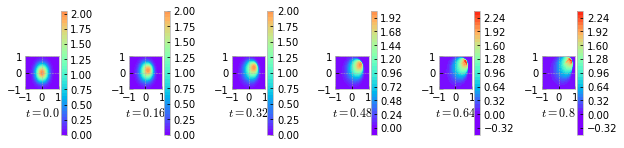

In [ ]:
from scipy.integrate import solve_ivp
from google.colab import files

burgsol = solve_ivp(brhs, (t0, tE), inivvec, t_eval=timegrid, method='RK23')
# burgsol = solve_ivp(brhs, (t0, tE), inivvec, t_eval=timegrid, method='BDF')
# burgsol = solve_ivp(brhs, (t0, tE), inivvec, t_eval=timegrid, method='Radau')
# burgsol = solve_ivp(brhs, (t0, tE), inivvec, t_eval=timegrid, method='LSODA')
# burgsol = solve_ivp(brhs, (t0, tE), inivvec, t_eval=timegrid)

if not burgsol.status == 0:
    print(burgsol.message)  # for some parameters there might be shocks
fullsol = burgsol.y

for k, cidx in enumerate(pltgrid):
    csol = fullsol[:, cidx]
    xlab = '$t={0}$'.format(timegrid[cidx])
    plotabs(csol, fignum=5, vmax=vmax, spcls=nplts, spidx=k+1, xlabel=xlab)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:554: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  SparseEfficiencyWarning)


True
projection error for inival: 1.429e-02
0.13652216867292902


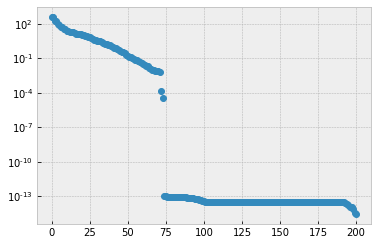

In [ ]:
from math import *
# L = np.linalg.cholesky(mmat.toarray())
snapshotder = np.zeros((burgsol.y.shape[0], burgsol.y.shape[1]-1))
for k in range(snapshotder.shape[1]):
  snapshotder[:,k] = (burgsol.y[:,k+1]-burgsol.y[:,k])/((tE - t0)/ 100)
snapfull = np.concatenate((burgsol.y, snapshotder), axis = 1)

snapshotmat = weightfac.Ft.dot(snapfull)
podmodes, svals, _ = spla.svd(1/sqrt(201)*snapshotmat, full_matrices=False)

plt.figure(303)
plt.semilogy(svals, 'o')
plt.savefig("regurlar_value.png")
#files.download("regurlar_value.png") 

podvecs = weightfac.solve_Ft(podmodes[:, :poddim])

print(np.allclose(np.eye(poddim), podvecs.T.dot(weightmat.dot(podvecs))))
prjinivvec = podvecs.T.dot(weightmat.dot(inivvec))
iniprjerr = mnorm(inivvec - podvecs.dot(prjinivvec))
errprj_w = weightnorm(inivvec - podvecs.dot(prjinivvec))
print('projection error for inival: {0:.3e}'.format(iniprjerr))
print(errprj_w)

In [ ]:
from numpy.linalg import matrix_rank
np.sum(svals[0:poddim])/np.sum(svals[0:matrix_rank(fullsol)])

0.9964166546848774

In [ ]:
nu_amat = 1/nu * amat
matrix_plus = mfac.solve_M(nu_amat.dot(podvecs))
matrix_add =  podvecs.T.dot(amat.dot(matrix_plus))

--- 23.507853269577026 seconds ---


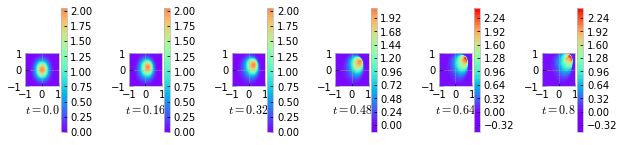

In [ ]:
redamat = podvecs.T.dot(amat.dot(podvecs)) + matrix_add
import time
start_time = time.time()
def redbrhs(time, redvec):
    inflatedv = podvecs.dot(redvec)
    redconv1 = podvecs.T.dot(burgers_nonl_vec(inflatedv))
    redconv = redconv1 + matrix_plus.T.dot(burgers_nonl_vec(inflatedv))
    return -redamat.dot(redvec) - redconv.flatten()


redburgsol = solve_ivp(redbrhs, (t0, tE), prjinivvec,t_eval=timegrid, method='RK23')
podredsol = redburgsol.y

for k, cidx in enumerate(pltgrid):
    csol = podvecs.dot(podredsol[:, cidx])
    xlab = '$t={0}$'.format(timegrid[cidx])
    plotabs(csol, fignum=6, vmax=vmax, spcls=nplts, spidx=k+1, xlabel=xlab)
    fsol = fullsol[:, cidx]

tlist, errlist = [], []
print("--- %s seconds ---" % (time.time() - start_time))

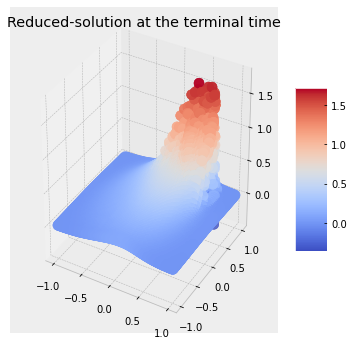

In [ ]:
coordinates = V.tabulate_dof_coordinates()
coordinates_X = coordinates[:,0]
coordinates_Y = coordinates[:,1]

projvec = podvecs.dot(podredsol)
plot_3d(coordinates_X, coordinates_Y, projvec, 100)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2ca087824bcdb4729fbdbae9495b07cb375bf0b2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_10518]'
  Unique elements:           'CG1(?,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, 
                             CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0438397 seconds.

INFO:FFC:Compiler

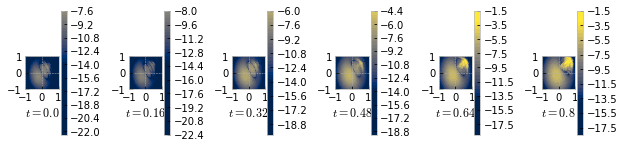

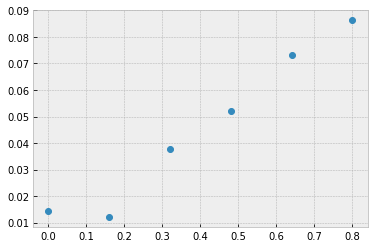

In [ ]:
for k, cidx in enumerate(pltgrid):
    plt.figure(6,figsize=(10,10))
    fsol = fullsol[:, cidx]
    csol = podvecs.dot(podredsol[:, cidx])
    diff = csol-fsol
    sqrtlogdiff = np.sqrt(np.abs(.5*np.log((csol-fsol)**2)))
    sqrtlogdiffun = dolfin.Function(V)
    sqrtlogdiffun.vector().set_local(sqrtlogdiff)
    plt.subplot(1, nplts, k+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1.5)
    cplt = dolfin.plot(-dolfin.inner(sqrtlogdiffun, sqrtlogdiffun))
    cplt.set_cmap('cividis')
    cplt.set_clim(vmin=-14, vmax=-3)
    xlab = '$t={0}$'.format(timegrid[cidx])
    plt.xlabel(xlab)
    plt.colorbar(cplt)
    errlist.append(mnorm(diff))
    tlist.append(timegrid[cidx])

plt.figure(103)
plt.plot(tlist, errlist, 'o', label='POD')
plt.show(block=False)

In [ ]:
totallerror = []
for i in range(1,Nts,1):
  diff_i = fullsol[:,i] - podvecs.dot(podredsol)[:,i]
  localerror_i = mnorm(diff_i)**2
  totallerror.append(localerror_i)

In [ ]:
1/100*np.sum(totallerror)

0.0026962647947586867

In [ ]:
from scipy.optimize import fsolve
def backward_euler ( rhs, tspan, y0, n ):

  if ( np.ndim ( y0 ) == 0 ):
    m = 1
  else:
    m = len ( y0 )

  t = np.zeros ( n + 1 )
  y = np.zeros ( [ n + 1, m ] )

  dt = ( tspan[1] - tspan[0] ) / float ( n )

  t[0] = tspan[0];
  y[0,:] = y0

  for i in range ( 0, n ):

    to = t[i]
    yo = y[i,:]
    tp = t[i] + dt
    yp = yo + dt * rhs( to, yo )

    yp = fsolve ( backward_euler_residual, yp, args = ( rhs, to, yo, tp ) )

    t[i+1]   = tp
    y[i+1,:] = yp[:]

  return t, y.T

def backward_euler_residual ( yp, rhs, to, yo, tp ):
  value = yp - yo - ( tp - to ) * rhs( tp, yp );
  return value

In [ ]:
time_grid_t,y_solred = backward_euler(redbrhs,[t0, tE],prjinivvec,100)

--- 173.6083128452301 seconds ---


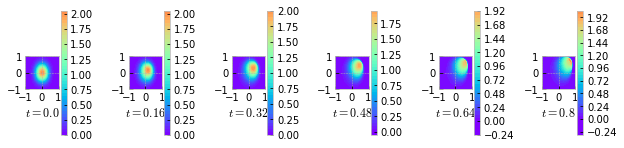

In [ ]:
for k, cidx in enumerate(pltgrid):
    csol = podvecs.dot(y_solred[:, cidx])
    xlab = '$t={0}$'.format(timegrid[cidx])
    plotabs(csol, fignum=6, vmax=vmax, spcls=nplts, spidx=k+1, xlabel=xlab)
    fsol = fullsol[:, cidx]

tlist, errlist = [], []
print("--- %s seconds ---" % (time.time() - start_time))

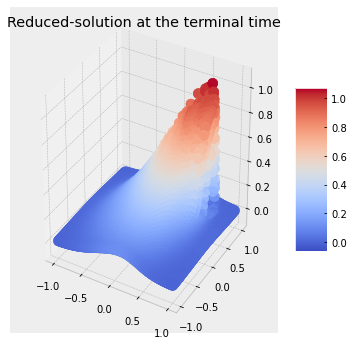

In [ ]:
coordinates = V.tabulate_dof_coordinates()
coordinates_X = coordinates[:,0]
coordinates_Y = coordinates[:,1]

projvec = podvecs.dot(y_solred)
plot_3d(coordinates_X, coordinates_Y, projvec, 100)

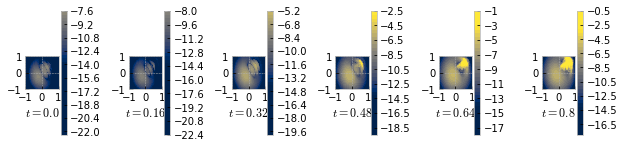

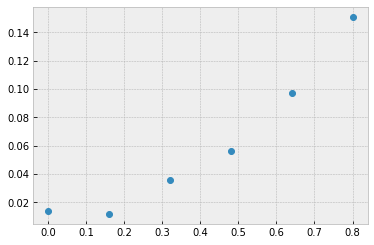

In [ ]:
for k, cidx in enumerate(pltgrid):
    plt.figure(6,figsize=(10,10))
    fsol = fullsol[:, cidx]
    csol = podvecs.dot(y_solred[:, cidx])
    diff = csol-fsol
    sqrtlogdiff = np.sqrt(np.abs(.5*np.log((csol-fsol)**2)))
    sqrtlogdiffun = dolfin.Function(V)
    sqrtlogdiffun.vector().set_local(sqrtlogdiff)
    plt.subplot(1, nplts, k+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1.5)
    cplt = dolfin.plot(-dolfin.inner(sqrtlogdiffun, sqrtlogdiffun))
    cplt.set_cmap('cividis')
    cplt.set_clim(vmin=-14, vmax=-3)
    xlab = '$t={0}$'.format(timegrid[cidx])
    plt.xlabel(xlab)
    plt.colorbar(cplt)
    errlist.append(mnorm(diff))
    tlist.append(timegrid[cidx])

plt.figure(103)
plt.plot(tlist, errlist, 'o', label='POD')
plt.show(block=False)

In [ ]:
totallerror = []
for i in range(1,Nts,1):
  diff_i = fullsol[:,i] - podvecs.dot(y_solred)[:,i]
  localerror_i = mnorm(diff_i)**2
  totallerror.append(localerror_i)

In [ ]:
1/100*np.sum(totallerror)

0.00502521180156913